# <center> **CLIM 680 Assignment** </center>

```
The following notebook makes use of Soil Moisture Active Passive (SMAP) Level 4 (L4) data which consists of the assimilation of raw or corrected measurements into a land surface model to produce geophysical parameters. Data files from 20210627 are obtained from the Center for Ocean-Land-Atmosphere Studies' remote server, though they are publicly available through NASA-designated data centers. The file contains information pertaining to the heat flux, soil moisture, and surface state variables at the stated time. This dataset was chosen because it is relevant to my research.
```

## Table of Contents

---
* [Imports](#Imports)
* [Assignment One](#AOne)
    * [Data Info and Access](#DataAc1)
    * [Filled Contour](#Contour)
    * [Filled Contour Map](#Map)
* [Assignment Two](#ATwo)
    * [Multi-File Access](#DataAc2)
    * [Data Aggregation](#Groupby)
    * [Climatology](#Clim)
        * [Net Radiation Flux](#NetRad)
        * [Latent Heat Flux](#LHF)
        * [Sensible Heat Flux](#SHF)
        * [Ground Heat Flux](#GHF)
* [Assignment Three](#AThree)
    * [Composite Data](#Comp)
    
---

## Imports<a class="anchor" id="Imports"></a>

In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import glob
import calendar
from datetime import datetime
from dateutil.relativedelta import relativedelta
from shapely.geometry.polygon import LinearRing
import matplotlib.patches as mpatches

In [2]:
#import sys
#!conda install -c conda-forge --yes --prefix {sys.prefix} h5netcdf

In [3]:
#xr.__version__

## Assignment One<a class="anchor" id="AOne"></a>

### Data Info & Access<a class="anchor" id="DataAc1"></a>

In [12]:
file = "/shared/land/SMAP/latest_L4/daily/SMAP_L4_SM_gph_20210627.nc4"
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:                            (x: 3856, y: 1624)
Coordinates:
  * x                                  (x) float64 -1.736e+07 ... 1.736e+07
  * y                                  (y) float64 7.31e+06 ... -7.31e+06
Data variables:
    EASE2_global_projection            |S1 ...
    cell_column                        (y, x) float64 ...
    cell_lat                           (y, x) float32 ...
    cell_lon                           (y, x) float32 ...
    cell_row                           (y, x) float64 ...
    time                               datetime64[ns] ...
    baseflow_flux                      (y, x) float32 ...
    heat_flux_ground                   (y, x) float32 ...
    heat_flux_latent                   (y, x) float32 ...
    heat_flux_sensible                 (y, x) float32 ...
    height_lowatmmodlay                (y, x) float32 ...
    land_evapotranspiration_flux       (y, x) float32 ...
    land_fraction_saturated            (y, x) float32 ...
   

### Filled Contour<a class="anchor" id="Contour"></a>

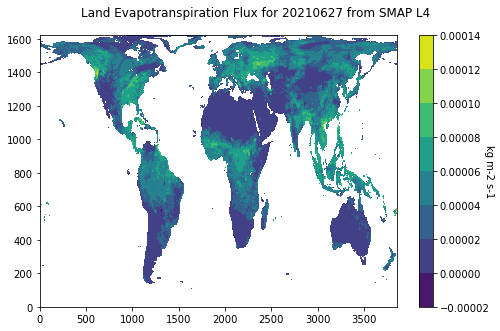

In [32]:
fig = plt.figure(figsize=(8,5))
plt.contourf(ds["land_evapotranspiration_flux"][-1::-1,:]);
cbar = plt.colorbar()
cbar.set_label('kg m-2 s-1', rotation=270)
plt.suptitle("Land Evapotranspiration Flux for 20210627 from SMAP L4", fontsize=12, y=.96)
plt.savefig('Figs/LandEvap_Contour.png')

### Filled Contour Map<a class="anchor" id="Map"></a>

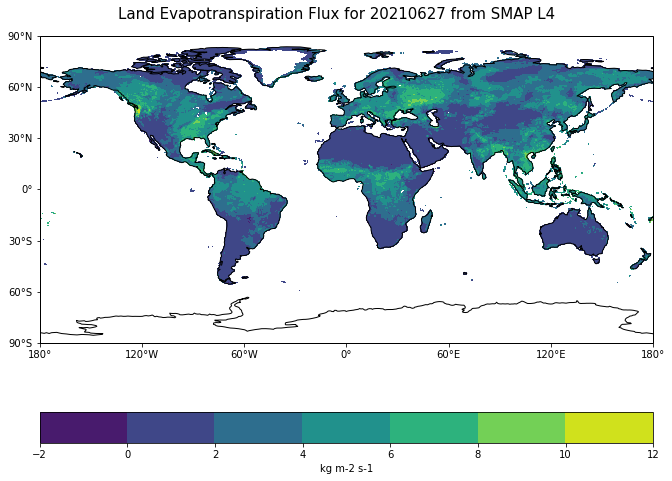

In [33]:
# Set size of image
fig = plt.figure(figsize=(11,8.5))

# Set the axes projection for plot
ax = plt.axes(projection=ccrs.PlateCarree())

# Make a filled contour plot
cs = ax.contourf(ds['cell_lon'], ds['cell_lat'], ds['land_evapotranspiration_flux']*86400, transform = ccrs.PlateCarree())

# Add Coastlines
ax.coastlines()

# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

cbar = plt.colorbar(cs, orientation='horizontal', label = 'kg m-2 s-1')
plt.suptitle("Land Evapotranspiration Flux for 20210627 from SMAP L4", fontsize=15, y=.90)
plt.savefig('Figs/LandEvap_CartopyContour.png')

## Assignment Two<a class="anchor" id="ATwo"></a>

### Multi-File Access<a class="anchor" id="DataAc2"></a>

In [4]:
ds2_list = glob.glob("/shared/land/SMAP/latest_L4/daily/SMAP_L4_SM_gph_201*.nc4")
#netcdf_list

In [5]:
ds2 = xr.open_mfdataset(paths=ds2_list, combine='nested', concat_dim='time').isel(y=slice(600,120, -1), 
                                                                                  x=slice(540,1280))
ds2

<xarray.Dataset>
Dimensions:                            (time: 1736, x: 740, y: 480)
Coordinates:
  * x                                  (x) float64 -1.25e+07 ... -5.842e+06
  * y                                  (y) float64 1.905e+06 ... 6.22e+06
  * time                               (time) datetime64[ns] 2016-03-25T01:28:55.816000 ... 2019-08-29T01:28:55.816000
Data variables:
    EASE2_global_projection            (time) |S1 b'' b'' b'' ... b'' b'' b''
    cell_column                        (time, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lat                           (time, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lon                           (time, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_row                           (time, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    baseflow_flux                      (time, y, x) float32 dask.array<chunksize=(1, 48

In [6]:
#Net Radiation variable (SWin-SWout-LWin-LWout)
Rad_da = ds2['net_downward_shortwave_flux'] - ds2['net_downward_longwave_flux']

### Data Aggregation<a class="anchor" id="Groupby"></a>

In [7]:
ds2_climo=ds2.groupby('time.month').mean(dim='time')
ds2_climo

<xarray.Dataset>
Dimensions:                            (month: 12, x: 740, y: 480)
Coordinates:
  * x                                  (x) float64 -1.25e+07 ... -5.842e+06
  * y                                  (y) float64 1.905e+06 ... 6.22e+06
  * month                              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    cell_column                        (month, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lat                           (month, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lon                           (month, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_row                           (month, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    baseflow_flux                      (month, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    heat_flux_ground                   (month, y, x) float32 dask.array<chunksize=(1, 4

In [8]:
#Create Climatology for Net Radiation
Rad_climo=Rad_da.groupby('time.month').mean(dim='time')

### 12-Panel Climatology<a class="anchor" id="Clim"></a>

#### Net Radiation<a class="anchor" id="NetRad"></a>

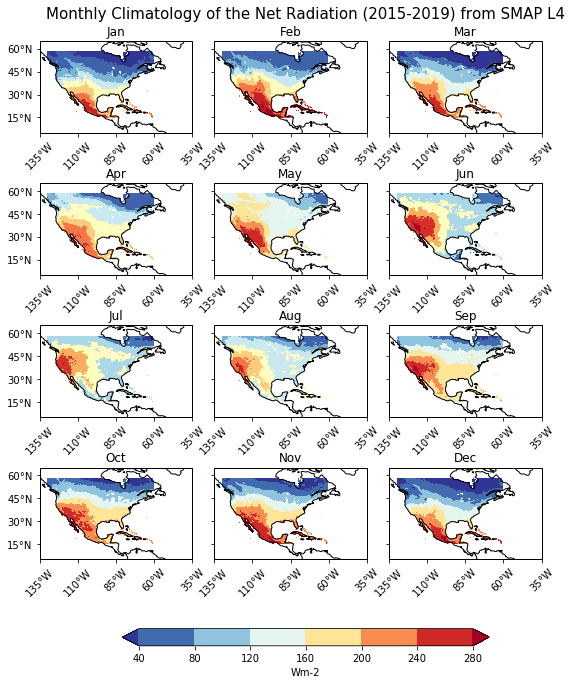

In [9]:
# Define the figure and each axis for the 4 rows and 3 columns
warnings.filterwarnings('ignore')
#clevs_Rad=np.arange(-280,280,40)

fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12), constrained_layout=True, sharey=True)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()


#Loop over all of the months and plot
for i in list(range(0,12)):
    
        # Contour plot
        cs=axs[i].contourf(ds2_climo["cell_lon"][i,:,:], ds2_climo['cell_lat'][i,:,:], Rad_climo[i,:,:],
                          transform = ccrs.PlateCarree(),
                          cmap='RdYlBu_r',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(calendar.month_abbr[i+1])
        
        # Set extent
        axs[i].set_extent([-135, -35, 5, 65], crs=ccrs.PlateCarree())
        
        # Longitude labels
        axs[i].set_xticks(np.arange(-135,-30,25), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='x', labelrotation = 45)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Draw the coastines for each subplot
        axs[i].coastlines()
        

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(left=0.05,
                   bottom=0.3,
                   right=0.9,
                   top=0.9,
                   wspace=0.02,
                   hspace=0.55)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Wm-2')

# Add a big title at the top
start = str(ds2.time.min().values)[0:4]
end = str(ds2.time.max().values)[0:4]
plt.suptitle("Monthly Climatology of the Net Radiation ("+start+"-"+end+") from SMAP L4", fontsize=15, y=.94)
plt.savefig('Figs/Climo_NetRad.png')

#### Latent Heat Flux<a class="anchor" id="LHF"></a>

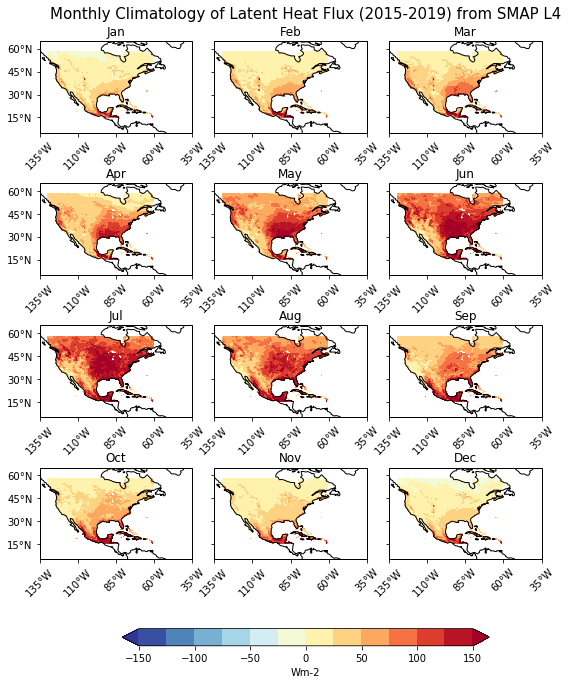

In [12]:
# Define the figure and each axis for the 4 rows and 3 columns
warnings.filterwarnings('ignore')
clevs_LH=np.arange(-150,151,25)

fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12), constrained_layout=True, sharey=True)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()


#Loop over all of the months and plot
for i in list(range(0,12)):
    
        # Contour plot
        cs=axs[i].contourf(ds2_climo["cell_lon"][i,:,:], ds2_climo['cell_lat'][i,:,:], ds2_climo["heat_flux_latent"][i,:,:],
                          clevs_LH, transform = ccrs.PlateCarree(),
                          cmap='RdYlBu_r',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(calendar.month_abbr[i+1])
        
        # Set extent
        axs[i].set_extent([-135, -35, 5, 65], crs=ccrs.PlateCarree())
        
        # Longitude labels
        axs[i].set_xticks(np.arange(-135,-30,25), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='x', labelrotation = 45)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Draw the coastines for each subplot
        axs[i].coastlines()
        

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(left=0.05,
                   bottom=0.3,
                   right=0.9,
                   top=0.9,
                   wspace=0.02,
                   hspace=0.55)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Wm-2')

# Add a big title at the top
start = str(ds2.time.min().values)[0:4]
end = str(ds2.time.max().values)[0:4]
plt.suptitle("Monthly Climatology of Latent Heat Flux ("+start+"-"+end+") from SMAP L4", fontsize=15, y=.94)
plt.savefig('Figs/Climo_LHF.png')

#### Sensible Heat Flux<a class="anchor" id="SHF"></a>

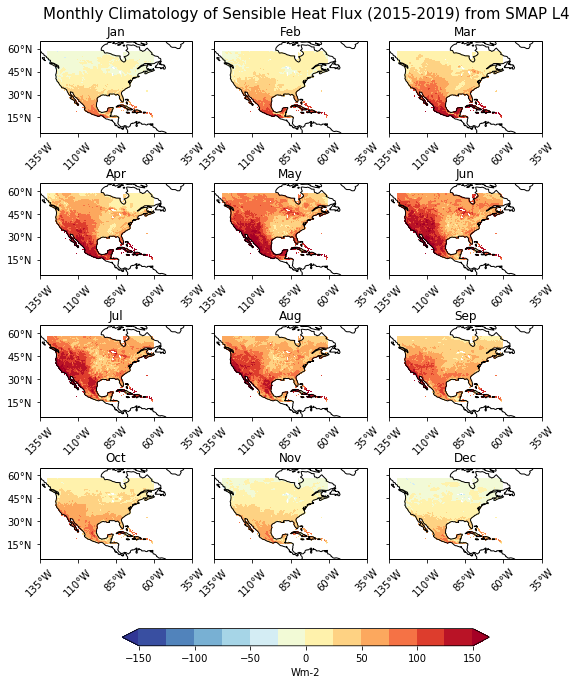

In [13]:
# Define the figure and each axis for the 4 rows and 3 columns
warnings.filterwarnings('ignore')
clevs_SH=np.arange(-150,151,25)

fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12), constrained_layout=True, sharey=True)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()


#Loop over all of the months and plot
for i in list(range(0,12)):
    
        # Contour plot
        cs=axs[i].contourf(ds2_climo["cell_lon"][i,:,:], ds2_climo['cell_lat'][i,:,:], ds2_climo["heat_flux_sensible"][i,:,:],
                          clevs_SH,transform = ccrs.PlateCarree(),
                          cmap='RdYlBu_r',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(calendar.month_abbr[i+1])
        
        # Set extent
        axs[i].set_extent([-135, -35, 5, 65], crs=ccrs.PlateCarree())
        
        # Longitude labels
        axs[i].set_xticks(np.arange(-135,-30,25), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='x', labelrotation = 45)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Draw the coastines for each subplot
        axs[i].coastlines()
        

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(left=0.05,
                   bottom=0.3,
                   right=0.9,
                   top=0.9,
                   wspace=0.02,
                   hspace=0.55)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Wm-2')

# Add a big title at the top
start = str(ds2.time.min().values)[0:4]
end = str(ds2.time.max().values)[0:4]
plt.suptitle("Monthly Climatology of Sensible Heat Flux ("+start+"-"+end+") from SMAP L4", fontsize=15, y=.94)
plt.savefig('Figs/Climo_SHF.png')

#### Ground Heat Flux<a class="anchor" id="GHF"></a>

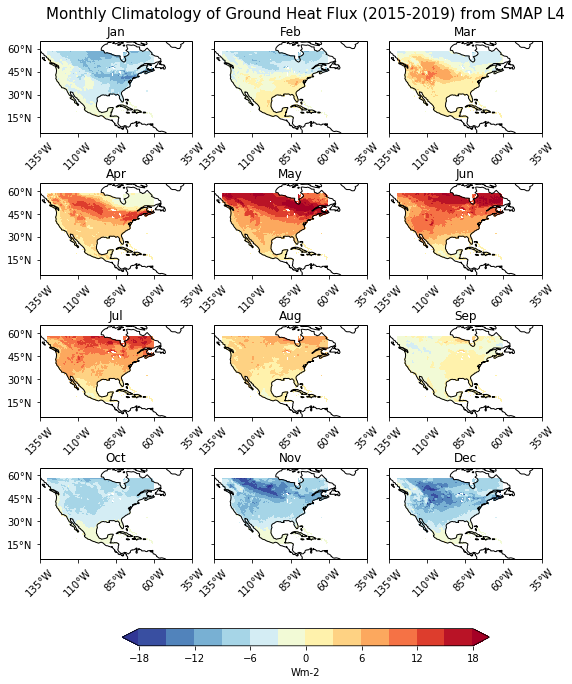

In [16]:
# Define the figure and each axis for the 4 rows and 3 columns
warnings.filterwarnings('ignore')
clevs_GH=np.arange(-18,19,3)

fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12), constrained_layout=True, sharey=True)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()


#Loop over all of the months and plot
for i in list(range(0,12)):
    
        # Contour plot
        cs=axs[i].contourf(ds2_climo["cell_lon"][i,:,:], ds2_climo['cell_lat'][i,:,:], ds2_climo["heat_flux_ground"][i,:,:],
                          clevs_GH, transform = ccrs.PlateCarree(),
                          cmap='RdYlBu_r',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(calendar.month_abbr[i+1])
        
        # Set extent
        axs[i].set_extent([-135, -35, 5, 65], crs=ccrs.PlateCarree())
        
        # Longitude labels
        axs[i].set_xticks(np.arange(-135,-30,25), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='x', labelrotation = 45)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Draw the coastines for each subplot
        axs[i].coastlines()
        

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(left=0.05,
                   bottom=0.3,
                   right=0.9,
                   top=0.9,
                   wspace=0.02,
                   hspace=0.55)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Wm-2')

# Add a big title at the top
start = str(ds2.time.min().values)[0:4]
end = str(ds2.time.max().values)[0:4]
plt.suptitle("Monthly Climatology of Ground Heat Flux ("+start+"-"+end+") from SMAP L4", fontsize=15, y=.94)
plt.savefig('Figs/Climo_GHF.png')

## Assignment Three<a class="anchor" id="AThree"></a>

### Composite Data<a class="anchor" id="Comp"></a>

In [10]:
#Create list of all SMAP files
ds3_list = glob.glob("/shared/land/SMAP/latest_L4/daily/SMAP_L4_SM_gph_20*.nc4") 

ds3_list.sort()
#ds3_list

In [11]:
#Open all files in list
ds3 = xr.open_mfdataset(paths=ds3_list, combine='nested', concat_dim='time').isel(y=slice(600,120, -1), 
                                                                                  x=slice(540,1280))

ds3 #Display xarray of data

<xarray.Dataset>
Dimensions:                            (time: 2345, x: 740, y: 480)
Coordinates:
  * x                                  (x) float64 -1.25e+07 ... -5.842e+06
  * y                                  (y) float64 1.905e+06 ... 6.22e+06
  * time                               (time) datetime64[ns] 2015-04-01T01:28:55.816000 ... 2021-08-31T01:28:55.816000
Data variables:
    EASE2_global_projection            (time) |S1 b'' b'' b'' ... b'' b'' b''
    cell_column                        (time, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lat                           (time, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lon                           (time, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_row                           (time, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    baseflow_flux                      (time, y, x) float32 dask.array<chunksize=(1, 48

In [12]:
#Open files for regions correspondings with climate classification for composite
TrHum = xr.open_mfdataset(paths=ds3_list, combine='nested', concat_dim='time').isel(y=slice(600,458,-1),
                                                                                      x=slice(962,1170))
Tm = xr.open_mfdataset(paths=ds3_list, combine='nested', concat_dim='time').isel(y=slice(400,280,-1), 
                                                                                 x=slice(978,1115))
Dr = xr.open_mfdataset(paths=ds3_list, combine='nested', concat_dim='time').isel(y=slice(450,335,-1),
                                                                                 x=slice(695,850))

In [13]:
#Create time average of Latent Heat Flux over US
ds3_tmavg_lat=ds3['cell_lat'].mean(dim='time').load()
ds3_tmavg_lon=ds3['cell_lon'].mean(dim='time').load()
ds3_tmavg_LHF=ds3['heat_flux_latent'].mean(dim='time').load()

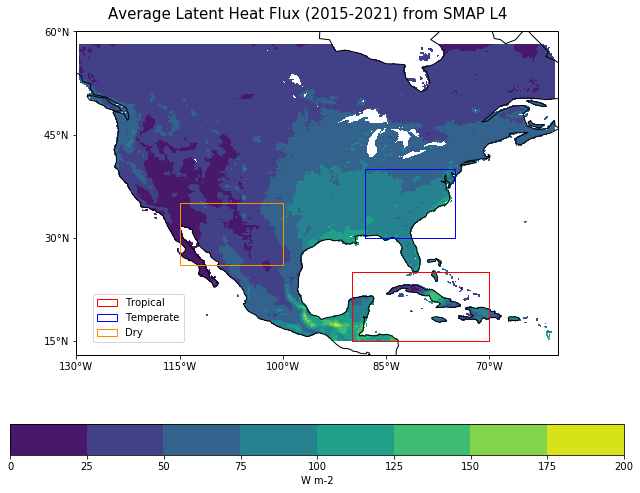

In [14]:
# Set size of image
fig = plt.figure(figsize=(11,8.5))

# Set the axes projection for plot
ax = plt.axes(projection=ccrs.PlateCarree())

# Make a filled contour plot
cs = ax.contourf(ds3_tmavg_lon[:,:], ds3_tmavg_lat[:,:], ds3_tmavg_LHF[:,:], transform = ccrs.PlateCarree())

# Add Coastlines
ax.coastlines()

# Set extent
ax.set_extent([-130, -60, 13, 60], crs=ccrs.PlateCarree())
        
# Longitude labels
ax.set_xticks(np.arange(-130,-60,15), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax.set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Create Color bar
cbar = plt.colorbar(cs, orientation='horizontal', label = 'W m-2')
plt.suptitle("Average Latent Heat Flux (2015-2021) from SMAP L4", fontsize=15, y=.92)
#plt.savefig('Figs/LandEvap_CartopyContour.png')

#Trop. CLIM Region
lons_Tr= [-90, -90, -70, -70]
lats_Tr= [15, 25, 25, 15]
ring_Tr= LinearRing(list(zip(lons_Tr, lats_Tr)))
ax.add_geometries([ring_Tr], ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=1)
#plt.text(-90, 25, 'Tropical', horizontalalignment='right', color='red', transform=ccrs.PlateCarree())

#Temp. CLIM Region
lons_Tm= [-88, -88, -75, -75]
lats_Tm= [30, 40, 40, 30]
ring_Tm= LinearRing(list(zip(lons_Tm, lats_Tm)))
ax.add_geometries([ring_Tm], ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=1)
#plt.text(-78, 35, 'Temperate', horizontalalignment='right', color='red', size=12, transform=ccrs.PlateCarree())

#Dry CLIM Region
lons_Dr= [-115, -115, -100, -100]
lats_Dr= [26, 35, 35, 26]
ring_Dr= LinearRing(list(zip(lons_Dr, lats_Dr)))
ax.add_geometries([ring_Dr], ccrs.PlateCarree(), facecolor='none', edgecolor='darkorange', linewidth=1)
#plt.text(-109, 30, 'Dry', horizontalalignment='right', color='red', size=12, transform=ccrs.PlateCarree())

# make two proxy artists to add to a legend
trp = mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor="red")
tmp = mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor="blue")
dry = mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor="darkorange")
labels = ['Tropical',
              'Temperate',
              'Dry']
plt.legend([trp, tmp, dry], labels,
            loc='lower left', bbox_to_anchor=(0.025, 0.025), fancybox=True)
#plt.savefig('Figs/AVG_LHF.png')

In [15]:
#Calculate Average over Entire Region
ds3_avg_LHF=ds3_tmavg_LHF.mean(dim=('x', 'y')).load()

In [16]:
#Calculate Thresholds for Composite
Tr_LHF = TrHum['heat_flux_latent'].mean(dim=('time','x', 'y')).load()
Tm_LHF = Tm['heat_flux_latent'].mean(dim=('time','x', 'y')).load()
Dr_LHF = Dr['heat_flux_latent'].mean(dim=('time','x', 'y')).load()

In [17]:
#Print threshold values
print(Tr_LHF)
print(Tm_LHF)
print(Dr_LHF)
print(ds3_avg_LHF)

<xarray.DataArray 'heat_flux_latent' ()>
array(81.362656, dtype=float32)
<xarray.DataArray 'heat_flux_latent' ()>
array(79.41589, dtype=float32)
<xarray.DataArray 'heat_flux_latent' ()>
array(30.837135, dtype=float32)
<xarray.DataArray 'heat_flux_latent' ()>
array(48.85046, dtype=float32)


#### Creating Anomalies and Defining Latent Heat Flux Boundaries

In [18]:
#First create anomalies for index
ET_index=ds3['heat_flux_latent'].mean(dim=['x','y']).load()
ET_climo=ET_index.groupby('time.month').mean().load()
ET_anoms=ET_index.groupby('time.month')-ET_climo.load()
ET_3m_index=ET_anoms.rolling(time=3,center=True).mean().dropna(dim='time').load() 

#Hardcode thresholds
TrLHF=ET_3m_index.where(ET_3m_index>=33).load()
DrLHF=ET_3m_index.where(ET_3m_index<=-18).load()
TmLHF=ET_3m_index.where(np.logical_and(ET_3m_index>-18,
                                              ET_3m_index<33)).load()

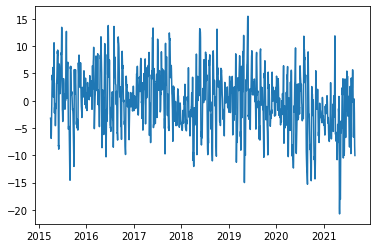

In [19]:
plt.plot(ET_3m_index['time'],ET_3m_index)

In [ ]:
# Create anomalies for the soil moisture profile
sm_climo=ds3['sm_profile'].groupby('time.month').mean().load()
sm_anoms=ds3['sm_profile'].groupby('time.month')-sm_climo.load()
sm_anoms = sm_anoms.assign_coords(lon=(ds3['cell_lon']), lat=(ds3['cell_lat'])).load()
sm_anoms

### Compose and Map Composite

In [ ]:
Tr_sm=sm_anoms.sel(time=TrLHF.dropna(dim='time')['time']).mean(dim='time').load()
Tm_sm=sm_anoms.sel(time=TmLHF.dropna(dim='time')['time']).mean(dim='time').load()
Dr_sm=sm_anoms.sel(time=DrLHF.dropna(dim='time')['time']).mean(dim='time').load()

In [ ]:
Dr_sm

In [159]:
comp_sm=[Tr_sm,Tm_sm,Dr_sm]
print(comp_sm)

[<xarray.DataArray 'sm_profile' (y: 480, x: 740)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float64 -1.25e+07 -1.249e+07 ... -5.851e+06 -5.842e+06
  * y        (y) float64 1.905e+06 1.914e+06 1.923e+06 ... 6.211e+06 6.22e+06, <xarray.DataArray 'sm_profile' (y: 480, x: 740)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.08144762, -0.0615857 , -0.05862066, ...,         nan,
                nan,         nan],
       [-0.05119886, -0.04875404,

ValueError: The coordinate must be equally spaced.

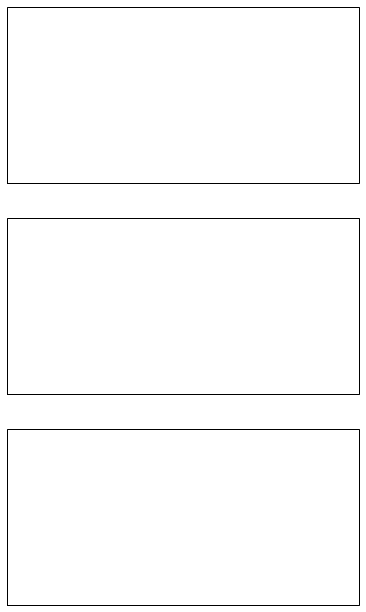

In [180]:
labels=['Tropical','Temperate', 'Dry']
#clevs=np.arange(-0.6,0.7,0.1)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,clim in enumerate(comp_sm):

        # Select the season
        data=comp_sm[i]

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds3['cell_lon'][1,1,:])

        # Contour plot
        cs=axs[i].contourf(lons,ds3['cell_lat'][1,:,1],data,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')
        
        # Set extent
        axs[i].set_extent([-130, -60, 13, 60], crs=ccrs.PlateCarree())
        
        # Longitude labels
        ax[i].set_xticks(np.arange(-130,-60,15), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='m3/m3')

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Anomalies in different Climate Regimes')

In [185]:
fig = plt.figure(figsize=(8,5))
cs = ax.contourf(ds3['cell_lon'][1,:,:], ds3['cell_lat'][1,:,:], Dr_sm[:,:], transform = ccrs.PlateCarree())
#plt.contourf(Dr_sm);
cbar = plt.colorbar()
cbar.set_label('kg m-2 s-1', rotation=270)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 576x360 with 0 Axes>

In [328]:
ds3=ds3.resample(time="1MS").mean(dim="time")